In [1]:
from pathlib import Path

import torch
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.utils.config import Config
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.datautils.utils import load_scaler

In [2]:
run_dir = Path("./runs/lstm_1607_123349")
# get basins
basins_path = Path("./basins.txt")
basins = pd.read_csv(basins_path, header=None)[0].tolist()
# hindcast.evaluate_basins(run_dir, basins)

In [3]:
basins_path = Path("./basins.txt")
basins = pd.read_csv(basins_path, header=None)[0].tolist()
type(basins[0])

int

In [4]:
BASIN_ID = 11129
EPOCH = 20

In [5]:
run_dir = Path("./runs/lstm_1607_123349")
config = Config(run_dir / "config.yml")
config.as_dict()

{'batch_size': 512,
 'clip_gradient_norm': 1,
 'commit_hash': 'b2e3136',
 'data_dir': PosixPath('../data/CAMELS_KZ'),
 'dataset': 'generic',
 'device': 'cuda:0',
 'dynamic_inputs': ['prcp',
  'srad',
  't_max',
  't_min',
  'pp_mean',
  'sat_max',
  'hum_mean',
  'dew_min',
  'discharge_prev'],
 'epochs': 20,
 'experiment_name': 'lstm',
 'head': 'regression',
 'hidden_size': 128,
 'img_log_dir': PosixPath('/home/spectre/Projects/ISSAI/Internship/aqua_rate/ML/runs/lstm_1607_123349/img_log'),
 'initial_forget_bias': 3,
 'learning_rate': {0: 0.01, 10: 0.001, 30: 0.0001, 40: 1e-05},
 'log_interval': 5,
 'log_tensorboard': True,
 'loss': 'NSE',
 'metrics': ['NSE', 'KGE'],
 'model': 'cudalstm',
 'num_workers': 8,
 'number_of_basins': 42,
 'optimizer': 'Adam',
 'output_activation': 'linear',
 'output_dropout': 0.4,
 'package_version': '1.10.0',
 'predict_last_n': 1,
 'run_dir': PosixPath('/home/spectre/Projects/ISSAI/Internship/aqua_rate/ML/runs/lstm_1607_123349'),
 'save_validation_results':

In [6]:
# config.update_config({"seq_length": 1})

In [7]:
model = CudaLSTM(cfg=config)
model

CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (model): CudaLSTMCore(
    (lstm): LSTM(31, 128)
    (dropout): Dropout(p=0.4, inplace=False)
    (head): Regression(
      (net): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=True)
      )
    )
  )
)

In [8]:
model.load_state_dict(torch.load(run_dir / f"model_epoch0{EPOCH}.pt"))
model

CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (model): CudaLSTMCore(
    (lstm): LSTM(31, 128)
    (dropout): Dropout(p=0.4, inplace=False)
    (head): Regression(
      (net): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=True)
      )
    )
  )
)

In [9]:
ds = get_dataset(cfg=config, is_train=False, basin=str(BASIN_ID), period="test", scaler=load_scaler(run_dir))
loader = DataLoader(ds, batch_size=1, num_workers=0, collate_fn=ds.collate_fn)

In [10]:
mean: np.ndarray = ds.scaler["xarray_feature_center"]["discharge"].data
std: np.ndarray = ds.scaler["xarray_feature_scale"]["discharge"].data
mean, std

(array(0.2724061, dtype=float32), array(2.5296144, dtype=float32))

In [11]:
def get_cmp(model, loader: DataLoader) -> tuple[list, list]:
    predictions = []
    actual = []

    for i, data in enumerate(loader):
        if i < 365:
            continue
        if i == 365 * 2:
            break

        x = model.pre_model_hook(data, is_train=False)
        y = x["y"].detach().numpy()[0][-1][0]
        y = y * std + mean
        actual.append(y)
        del x["y"]

        if i > 365:
            x["x_d"][0][-len(predictions):][:, 8] = torch.tensor(predictions)

        prediction = model(x)
        predictions.append(prediction["y_hat"].detach().numpy()[0][-1][0])

    predictions = np.array(predictions) * std.tolist() + mean.tolist()
    return predictions, actual

In [12]:
def plot_cmp(y_hat: list, y: list) -> None:
    df = pd.DataFrame({
        "Observed": y,
        "Predicted": y_hat,
    })

    sns.lineplot(df, linestyle="-")
    plt.savefig(run_dir / f"img_log/{BASIN_ID}_test_year2.png")

In [13]:
predictions = []
actual = []

for i, data in enumerate(loader):
    if i < 365:
        continue
    if i == 365 * 2:
    # if i == 365 + 3:
        break
    x = model.pre_model_hook(data, is_train=False)
    y = x["y"].detach().numpy()[0][-1][0]
    y = y * std + mean
    actual.append(y)
    del x["y"]

    # print()
    # print("Actual: ", y)
    # print(x["x_d"].shape)
    # print("x_d_prev: ", x["x_d"][0][-1][8])
    # try:
    #     print("last_pred: ", prediction["y_hat"].squeeze(0, -1))
    # except:
    #     pass

    if i > 365:
        # print(len(predictions))
        # print(x["x_d"][0][-len(predictions):])
        # print(x["x_d"][0][-len(predictions):][:, 8])
        x["x_d"][0][-len(predictions):][:, 8] = torch.tensor(predictions)

    # print("x_d_prev_new", x["x_d"][0][-1][8])
    # print("Current Input: ", x["x_d"])

    prediction = model(x)
    predictions.append(prediction["y_hat"].detach().numpy()[0][-1][0])
    # print("current_pred: ", prediction["y_hat"].squeeze(0, -1))
    # print(prediction["y_hat"].detach().numpy()[0][-1][0] * std.tolist() + mean.tolist())

In [14]:
y_pred = np.array(predictions) * std.tolist() + mean.tolist()

In [15]:
len(predictions)

365

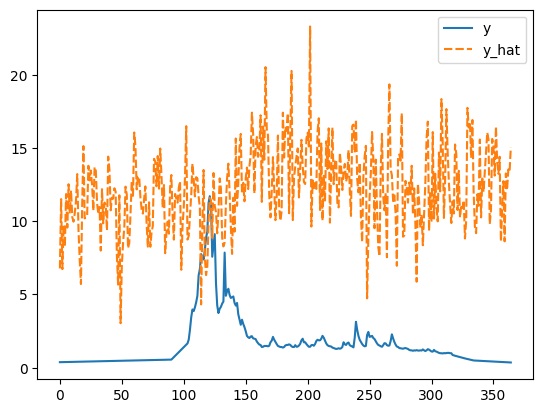

In [16]:
df = pd.DataFrame({
    "y": actual,
    "y_hat": y_pred,
})

sns.lineplot(df)
plt.savefig(run_dir / f"img_log/{BASIN_ID}_test_year2.png")

In [17]:
data = next(iter(loader))
x = model.pre_model_hook(data, is_train=False)
x["y"].shape

torch.Size([1, 365, 1])

In [27]:
for key, value in next(iter(loader)).items():
    print(f"{key}: {value.shape}")

x_d: torch.Size([1, 365, 9])
y: torch.Size([1, 365, 1])
date: (1, 365)
x_s: torch.Size([1, 22])
per_basin_target_stds: torch.Size([1, 1, 1])


In [18]:
next(iter(loader))["x_d"]

tensor([[[-0.3361, -0.5220, -1.5958,  ..., -0.6359, -1.9607,  0.0284],
         [-0.3361, -0.4930, -1.4973,  ..., -1.1826, -1.7808,  0.0253],
         [-0.3361, -0.4768, -1.5104,  ..., -1.0004, -1.8408,  0.0222],
         ...,
         [-0.3361, -0.4313, -1.0834,  ..., -0.8182, -1.3526,  0.1058],
         [-0.3361, -0.8267, -1.3396,  ...,  0.7004, -0.9758,  0.1067],
         [ 0.1848, -0.8204, -1.4775,  ...,  1.4901, -1.2327,  0.1076]]])

In [19]:
next(iter(loader))["x_d"].shape

torch.Size([1, 365, 9])

In [21]:
next(iter(loader))["x_s"].shape

torch.Size([1, 22])

In [23]:
next(iter(loader))["date"].shape

(1, 365)

In [19]:
for i, data in enumerate(loader):
    if i == 365:
        x = data

In [20]:
x = model.pre_model_hook(data, is_train=False)

In [21]:
y = model(x)
y["y_hat"]

tensor([[[ 0.2237],
         [ 0.1860],
         [ 0.0077],
         [-0.0462],
         [-0.0625],
         [-0.0623],
         [-0.0505],
         [-0.0752],
         [-0.0544],
         [-0.0673],
         [-0.0715],
         [-0.0630],
         [-0.0852],
         [-0.0610],
         [-0.0733],
         [-0.0874],
         [-0.0696],
         [-0.0750],
         [-0.0693],
         [-0.0701],
         [-0.0836],
         [-0.0786],
         [-0.0587],
         [-0.0791],
         [-0.0836],
         [-0.0716],
         [-0.0780],
         [-0.0670],
         [-0.0633],
         [-0.0682],
         [-0.0794],
         [-0.0628],
         [-0.0711],
         [-0.0668],
         [-0.0796],
         [-0.0726],
         [-0.0686],
         [-0.0755],
         [-0.0691],
         [-0.0601],
         [-0.0533],
         [-0.0617],
         [-0.0714],
         [-0.0648],
         [-0.0576],
         [-0.0657],
         [-0.0705],
         [-0.0525],
         [-0.0578],
         [-0.0711],


In [22]:
y["y_hat"][0].shape, x["y"][0].shape

(torch.Size([365, 1]), torch.Size([365, 1]))

In [23]:
y_hat = y["y_hat"].squeeze(0, -1) * std.tolist() + mean.tolist()

In [24]:
y_hat.shape

torch.Size([365])

In [25]:
y_hat

tensor([0.8383, 0.7430, 0.2918, 0.1557, 0.1142, 0.1148, 0.1446, 0.0822, 0.1349,
        0.1021, 0.0916, 0.1131, 0.0569, 0.1181, 0.0869, 0.0514, 0.0963, 0.0826,
        0.0970, 0.0950, 0.0609, 0.0736, 0.1239, 0.0723, 0.0611, 0.0913, 0.0751,
        0.1030, 0.1122, 0.0998, 0.0714, 0.1134, 0.0925, 0.1034, 0.0712, 0.0888,
        0.0988, 0.0815, 0.0976, 0.1204, 0.1376, 0.1164, 0.0918, 0.1085, 0.1267,
        0.1063, 0.0942, 0.1395, 0.1261, 0.0926, 0.1281, 0.1287, 0.1243, 0.1435,
        0.1627, 0.1013, 0.0914, 0.1458, 0.0817, 0.0877, 0.1522, 0.1548, 0.1553,
        0.1276, 0.1364, 0.1104, 0.1180, 0.1236, 0.1592, 0.1093, 0.1600, 0.1257,
        0.1758, 0.1244, 0.1266, 0.1679, 0.1664, 0.1312, 0.1320, 0.2007, 0.2084,
        0.2412, 0.1799, 0.2162, 0.2223, 0.2603, 0.2448, 0.3505, 0.2154, 0.3460,
        0.2781, 0.3474, 0.3325, 0.3075, 0.3399, 0.3326, 0.3958, 0.2692, 0.3846,
        0.3482, 0.3092, 0.3320, 0.3804, 0.3114, 0.4817, 0.3005, 0.2656, 0.3703,
        0.5413, 0.5314, 0.6438, 0.5610, 

<Axes: >

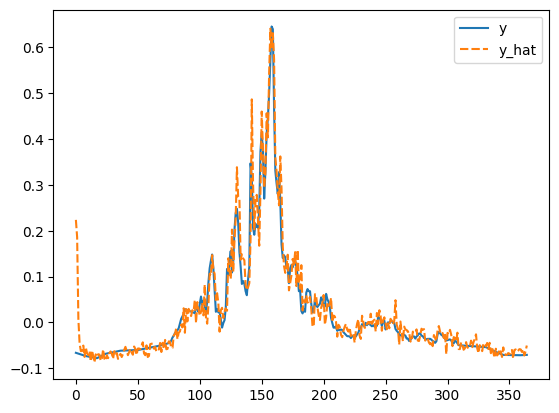

In [27]:
df = pd.DataFrame({
    "y": x["y"].squeeze(0, -1).detach().numpy(),
    "y_hat": y["y_hat"].squeeze(0, -1).detach().numpy(),
})

sns.lineplot(df)

In [ ]:
next(iter(loader))['x_d'].shape, next(iter(loader))['x_s'].shape, next(iter(loader))['y'].shape

(torch.Size([1, 1, 10]), torch.Size([1, 22]), torch.Size([1, 1, 1]))

In [ ]:
for data in loader:
    for key in data:
        if not key.startswith('date'):
            data[key] = data[key].to("cuda")

In [19]:
next(iter(loader))

{'x_d': tensor([[[ 0.1848, -1.1343, -1.2542, -1.1256, 46.2239, -0.8776,  0.9434,
           -1.0572, -0.1291, -0.0567]]]),
 'y': tensor([[[-0.1291]]]),
 'date': array([['2019-01-01T00:00:00.000000000']], dtype='datetime64[ns]'),
 'x_s': tensor([[ 3.3826, -0.3711, -1.5638,  2.2399,  0.2320,  1.2555, -0.3107, -0.3445,
           2.0607,  2.2140, -0.0611, -0.0572, -0.2465, -0.0210, -0.9132,  0.1899,
          -1.0894,  0.1022,  0.4851,  0.5518,  1.8709,  1.4554]]),
 'per_basin_target_stds': tensor([[[0.2768]]])}

In [20]:
input_data = model_lstm.pre_model_hook(next(iter(loader)), is_train=False)

NameError: name 'model_lstm' is not defined

In [ ]:
input_data

{'x_d': tensor([[[-0.3361, -1.0030, -1.6943,  ..., -1.9821,  0.3249,  0.0599],
          [-0.3361, -1.0140, -1.5761,  ..., -2.1448,  0.3290,  0.0599],
          [-0.3361, -0.9820, -1.6812,  ..., -2.0634,  0.3290,  0.0858],
          ...,
          [-0.3361, -1.0301, -1.2312,  ..., -1.4211,  0.1857, -0.0696],
          [-0.3361, -1.1649, -1.1984,  ..., -1.0914,  0.1902, -0.0567],
          [ 0.1848, -1.1343, -1.2542,  ..., -1.0572,  0.1942, -0.0567]]]),
 'y': tensor([[[   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan]

In [16]:
pred = model_lstm(input_data)

In [17]:
pred

{'y_hat': tensor([[[ 1.8648e-02],
          [-6.2468e-02],
          [-3.7423e-02],
          [-7.5205e-02],
          [ 2.1293e-02],
          [-4.4056e-03],
          [ 2.3969e-01],
          [-3.4571e-02],
          [-1.6828e-01],
          [-1.1205e-01],
          [-6.3946e-02],
          [ 1.0819e-02],
          [ 1.6373e-04],
          [-1.7956e-01],
          [-1.0694e-01],
          [ 1.9756e-01],
          [ 1.2559e-01],
          [ 2.1452e-02],
          [-3.6350e-01],
          [ 2.6217e-01],
          [ 4.8798e-02],
          [ 2.0511e-01],
          [-1.5484e-01],
          [-4.5281e-02],
          [ 2.7673e-01],
          [-2.6210e-01],
          [ 1.8491e-01],
          [ 1.7059e-01],
          [ 1.0251e-01],
          [ 4.7822e-01],
          [ 1.6325e-01],
          [ 2.9026e-01],
          [ 3.1735e-01],
          [ 2.1961e-01],
          [-9.4856e-02],
          [-1.6361e-01],
          [-4.2429e-02],
          [ 2.1902e-01],
          [ 1.5313e-01],
          [-8.06

In [18]:
pred["y_hat"], pred["y_hat"].shape

(tensor([[[ 1.8648e-02],
          [-6.2468e-02],
          [-3.7423e-02],
          [-7.5205e-02],
          [ 2.1293e-02],
          [-4.4056e-03],
          [ 2.3969e-01],
          [-3.4571e-02],
          [-1.6828e-01],
          [-1.1205e-01],
          [-6.3946e-02],
          [ 1.0819e-02],
          [ 1.6373e-04],
          [-1.7956e-01],
          [-1.0694e-01],
          [ 1.9756e-01],
          [ 1.2559e-01],
          [ 2.1452e-02],
          [-3.6350e-01],
          [ 2.6217e-01],
          [ 4.8798e-02],
          [ 2.0511e-01],
          [-1.5484e-01],
          [-4.5281e-02],
          [ 2.7673e-01],
          [-2.6210e-01],
          [ 1.8491e-01],
          [ 1.7059e-01],
          [ 1.0251e-01],
          [ 4.7822e-01],
          [ 1.6325e-01],
          [ 2.9026e-01],
          [ 3.1735e-01],
          [ 2.1961e-01],
          [-9.4856e-02],
          [-1.6361e-01],
          [-4.2429e-02],
          [ 2.1902e-01],
          [ 1.5313e-01],
          [-8.0654e-03],


In [19]:
model = model_lstm.model
model

CudaLSTMCore(
  (lstm): LSTM(32, 128)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [20]:
next(iter(loader))

{'x_d': tensor([[[-0.3361, -1.0030, -1.6943,  ..., -1.9821,  0.3249,  0.0599],
          [-0.3361, -1.0140, -1.5761,  ..., -2.1448,  0.3290,  0.0599],
          [-0.3361, -0.9820, -1.6812,  ..., -2.0634,  0.3290,  0.0858],
          ...,
          [-0.3361, -1.0301, -1.2312,  ..., -1.4211,  0.1857, -0.0696],
          [-0.3361, -1.1649, -1.1984,  ..., -1.0914,  0.1902, -0.0567],
          [ 0.1848, -1.1343, -1.2542,  ..., -1.0572,  0.1942, -0.0567]]]),
 'y': tensor([[[   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan],
          [   nan]

In [21]:
a = next(iter(loader))
a["x_s"] = a["x_s"].unsqueeze(0).expand(1, 365, 22)

In [22]:
a["x_s"].shape

torch.Size([1, 365, 22])

In [23]:
input_data = torch.cat([a["x_d"], a["x_s"]], dim=2)
input_data, input_data.shape

(tensor([[[-0.3361, -1.0030, -1.6943,  ...,  0.5518,  1.8709,  1.4554],
          [-0.3361, -1.0140, -1.5761,  ...,  0.5518,  1.8709,  1.4554],
          [-0.3361, -0.9820, -1.6812,  ...,  0.5518,  1.8709,  1.4554],
          ...,
          [-0.3361, -1.0301, -1.2312,  ...,  0.5518,  1.8709,  1.4554],
          [-0.3361, -1.1649, -1.1984,  ...,  0.5518,  1.8709,  1.4554],
          [ 0.1848, -1.1343, -1.2542,  ...,  0.5518,  1.8709,  1.4554]]]),
 torch.Size([1, 365, 32]))

In [24]:
loader = DataLoader(ds, batch_size=1024, num_workers=0, collate_fn=ds.collate_fn)

In [25]:
for data in loader:
    for key in data:
        if not key.startswith('date'):
            data[key] = data[key].to("cuda")

In [26]:
input_data = next(iter(loader))
input_data["x_d"].shape, input_data["x_s"].shape

(torch.Size([1024, 365, 10]), torch.Size([1024, 22]))

In [27]:
input_data["x_s"] = input_data["x_s"].unsqueeze(0).expand(365, 1024, 22).swapaxes(0, 1)
input_data["x_d"].shape, input_data["x_s"].shape

(torch.Size([1024, 365, 10]), torch.Size([1024, 365, 22]))

In [28]:
input_data = torch.cat([input_data["x_d"], input_data["x_s"]], dim=2)
input_data.shape

torch.Size([1024, 365, 32])

In [29]:
import shap


# batch = next(iter(loader))
# images, _ = batch

background = input_data
# test_images = images[100:103]

e = shap.DeepExplainer(model, background)
# shap_values = e.shap_values(test_images)

In [30]:
shap_values = e.shap_values(input_data, check_additivity=False)

/home/spectre/Projects/ISSAI/Internship/aqua_rate/.venv/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


KeyboardInterrupt: 

In [ ]:
# input_data.squeeze(0).shape

torch.Size([365, 32])

In [ ]:
shap_values.shape

(1, 365, 32, 1)

In [ ]:
import numpy as np


# shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(background.numpy(), 1, -1), 1, 2)
test_numpy.shape

(1, 365, 32)

In [ ]:
test_numpy = test_numpy.squeeze(0)
test_numpy.shape

(365, 32)

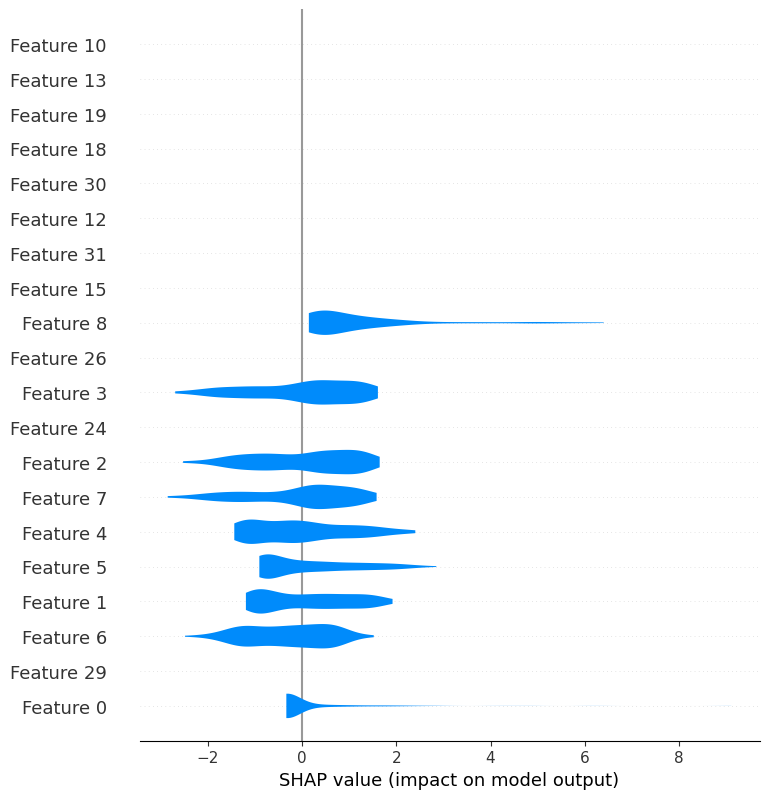

In [ ]:
shap.violin_plot(test_numpy)